In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/qn/rwmymx5114z9y_hst39rvm8r0000gn/T/ipykernel_98538/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print (most_recent_date)

2017-08-23


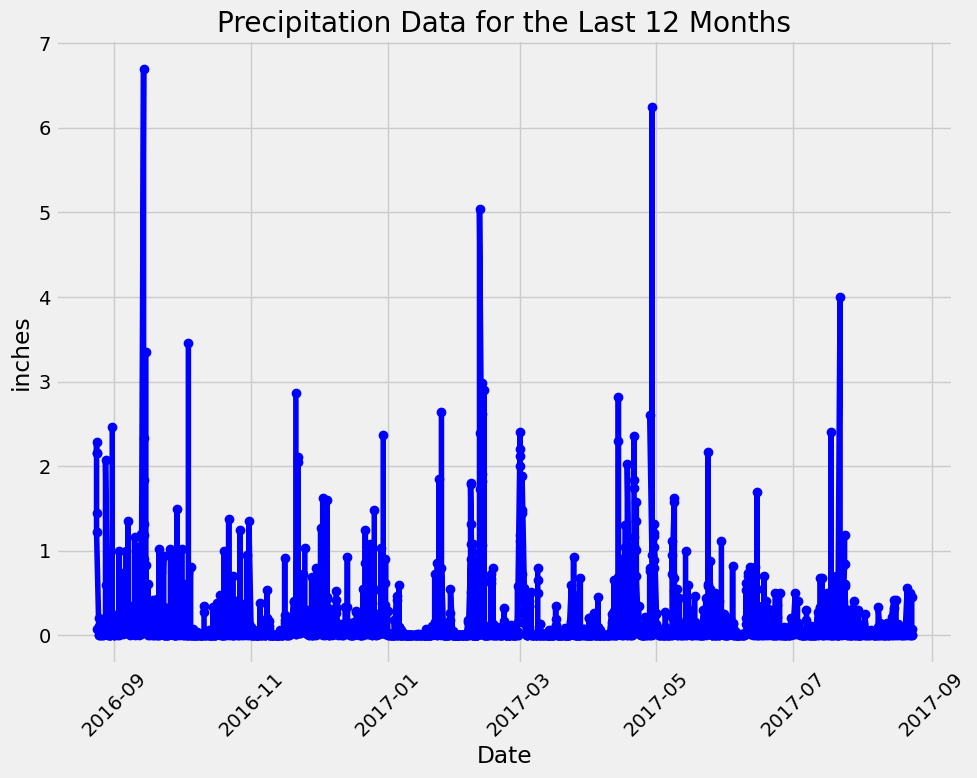

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta

most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.

one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['Precipitation'], marker='o', linestyle='-', color='b')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('inches')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_stats = df['Precipitation'].describe()
print (summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset

total_stations_query = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print (total_stations_query)


9


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
result = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the stations and their counts
print("Most Active Stations:")
for station, count in result:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
results = session.query(
    func.min(Measurement.tobs),  # Minimum temperature
    func.max(Measurement.tobs),  # Maximum temperature
    func.avg(Measurement.tobs)   # Average temperature
).filter(Measurement.station == most_active_station_id).all()
min_temp, max_temp, avg_temp = results[0]
print(f"Statistics for Station ID {most_active_station_id}:")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Statistics for Station ID USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


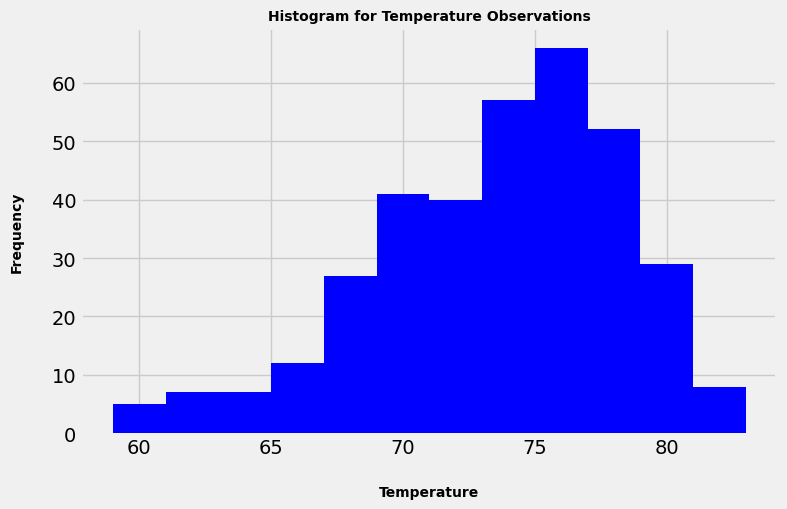

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'
most_recent_date_str = '2017-08-23'
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
query = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago
).all()

# Convert query results to a Pandas DataFrame
df = pd.DataFrame(query, columns=['tobs'])

plt.figure(figsize=(8, 5))
hist = df['tobs'].hist(bins=12, color='b', zorder=4)

# Customize the histogram
hist.set_title("Histogram for Temperature Observations", weight='bold', size=10)
hist.set_xlabel("Temperature", labelpad=20, weight='bold', size=10)
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=10)
plt.grid(True)

# Show the plot
plt.show()


# Close Session

In [51]:
# Close Session
session.close()